In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt



2025-07-06 16:36:55.249772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751819815.628828      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751819815.740011      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
train_dir = '/kaggle/input/potholes-classification-2/train'
test_dir = '/kaggle/input/potholes-classification-2/test'
valid_dir = '/kaggle/input/potholes-classification-2/valid'


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define training ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define validation/test ImageDataGenerator
test_valid_datagen = ImageDataGenerator(rescale=1./255)


In [8]:

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Updated to 224x224
    batch_size=32,
    class_mode='binary'
)

valid_generator = test_valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),  # Updated to 224x224
    batch_size=32,
    class_mode='binary'
)

test_generator = test_valid_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Updated to 224x224
    batch_size=32,
    class_mode='binary'
)


Found 14213 images belonging to 2 classes.
Found 2427 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.


In [10]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Load VGG19 without the fully connected layers (top)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# Freeze the VGG19 layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)  # Binary classification (pothole vs no pothole)

# Define the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 23,235,905 (88.64 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # You can adjust this based on your requirements
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1751820311.373310     122 service.cc:148] XLA service 0x7c382c00e000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751820311.374734     122 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751820311.374754     122 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751820311.905612     122 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/444 ━━━━━━━━━━━━━━━━━━━━ 1:55:24 16s/step - accuracy: 0.5625 - loss: 0.7229

I0000 00:00:1751820324.176764     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


444/444 ━━━━━━━━━━━━━━━━━━━━ 332s 715ms/step - accuracy: 0.7624 - loss: 0.6021 - val_accuracy: 0.9025 - val_loss: 0.2444
Epoch 2/10
  1/444 ━━━━━━━━━━━━━━━━━━━━ 1:48 245ms/step - accuracy: 0.6562 - loss: 0.4947

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.6562 - loss: 0.4947 - val_accuracy: 0.9017 - val_loss: 0.2497
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 220s 494ms/step - accuracy: 0.8331 - loss: 0.3754 - val_accuracy: 0.9038 - val_loss: 0.2320
Epoch 4/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7812 - loss: 0.4337 - val_accuracy: 0.9071 - val_loss: 0.2325
Epoch 5/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 214s 482ms/step - accuracy: 0.8339 - loss: 0.3644 - val_accuracy: 0.9129 - val_loss: 0.2228
Epoch 6/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.8750 - loss: 0.3595 - val_accuracy: 0.9150 - val_loss: 0.2182
Epoch 7/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 217s 488ms/step - accuracy: 0.8366 - loss: 0.3621 - val_accuracy: 0.9258 - val_loss: 0.2179
Epoch 8/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9375 - loss: 0.2947 - val_accuracy: 0.9246 - val_loss: 0.2184
Epoch 9/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 215s 483ms/step - accuracy: 0.8344 - loss: 0.3556 - val

In [12]:
# Unfreeze the last convolutional block of VGG19 (block5)
for layer in base_model.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4']:
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Optional: Check trainable layers
print("Trainable layers:")
for layer in model.layers:
    print(f"{layer.name}: {'Trainable' if layer.trainable else 'Frozen'}")


Trainable layers:
input_layer_1: Frozen
block1_conv1: Frozen
block1_conv2: Frozen
block1_pool: Frozen
block2_conv1: Frozen
block2_conv2: Frozen
block2_pool: Frozen
block3_conv1: Frozen
block3_conv2: Frozen
block3_conv3: Frozen
block3_conv4: Frozen
block3_pool: Frozen
block4_conv1: Frozen
block4_conv2: Frozen
block4_conv3: Frozen
block4_conv4: Frozen
block4_pool: Frozen
block5_conv1: Trainable
block5_conv2: Trainable
block5_conv3: Trainable
block5_conv4: Trainable
block5_pool: Frozen
flatten_1: Trainable
dense_2: Trainable
dropout_1: Trainable
dense_3: Trainable


In [13]:
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # or more depending on your needs
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)


Epoch 1/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 238s 517ms/step - accuracy: 0.8463 - loss: 0.3427 - val_accuracy: 0.9346 - val_loss: 0.1840
Epoch 2/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.8750 - loss: 0.2139 - val_accuracy: 0.9354 - val_loss: 0.1858
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 219s 492ms/step - accuracy: 0.8715 - loss: 0.2905 - val_accuracy: 0.9388 - val_loss: 0.1611
Epoch 4/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9062 - loss: 0.2566 - val_accuracy: 0.9400 - val_loss: 0.1582
Epoch 5/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 216s 486ms/step - accuracy: 0.8874 - loss: 0.2589 - val_accuracy: 0.9450 - val_loss: 0.1570
Epoch 6/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.8438 - loss: 0.2684 - val_accuracy: 0.9442 - val_loss: 0.1584
Epoch 7/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 218s 490ms/step - accuracy: 0.8977 - loss: 0.2331 - val_accuracy: 0.9492 - val_loss: 0.1486
Epoch 8/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9688 - loss: 0

In [14]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 366ms/step - accuracy: 0.9465 - loss: 0.1287
Test Loss: 0.13742150366306305
Test Accuracy: 0.9408783912658691


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


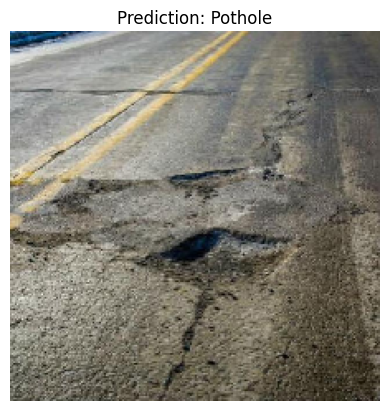

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Path to the image you want to predict
img_path = '/kaggle/input/potholes-classification-2/test/Pothole/105_jpg.rf.389e3f3aad0e701ba2a8d766194f6ad2.jpg'  # Replace with your image path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # Resize the image
img_array = image.img_to_array(img)  # Convert image to array
img_array = img_array / 255.0  # Rescale the image to match the model's input
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make prediction
prediction = model.predict(img_array)

# Show the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.title("Prediction: Pothole" if prediction[0] > 0.5 else "Prediction: No Pothole")
plt.show()


In [18]:
# Ground truth for the image (True Label)
true_label = 1  # If the image is a pothole, set it to 1, otherwise 0

# Compare predicted label with the true label
prediction = model.predict(img_array)
predicted_label = 1 if prediction[0] > 0.5 else 0  # If prediction > 0.5, it's Pothole (1), otherwise No Pothole (0)

# Check if the prediction is correct
correct = (predicted_label == true_label)
accuracy = (correct * 100)  # 100% if correct, 0% if incorrect

print(f"Prediction: {'Pothole' if predicted_label == 1 else 'No Pothole'}")
print(f"Accuracy: {accuracy}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction: Pothole
Accuracy: 100%


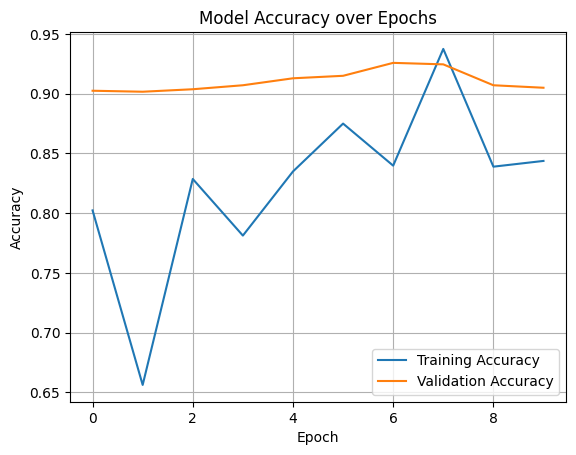

In [20]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [21]:
from tensorflow.keras.callbacks import Callback

class TestAccuracyCallback(Callback):
    def __init__(self, test_generator):
        super().__init__()
        self.test_generator = test_generator
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(
            self.test_generator,
            steps=self.test_generator.samples // self.test_generator.batch_size,
            verbose=0
        )
        self.test_accuracies.append(acc)
        print(f"\nTest accuracy after epoch {epoch+1}: {acc:.4f}")


In [22]:
# Initialize the callback
test_callback = TestAccuracyCallback(test_generator)

# Train the model with the callback
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[test_callback]
)


Epoch 1/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9204 - loss: 0.1982
Test accuracy after epoch 1: 0.9409
444/444 ━━━━━━━━━━━━━━━━━━━━ 232s 521ms/step - accuracy: 0.9205 - loss: 0.1981 - val_accuracy: 0.9500 - val_loss: 0.1405
Epoch 2/10
  1/444 ━━━━━━━━━━━━━━━━━━━━ 2:10 295ms/step - accuracy: 0.9062 - loss: 0.2325
Test accuracy after epoch 2: 0.9434
444/444 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.9062 - loss: 0.2325 - val_accuracy: 0.9504 - val_loss: 0.1396
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9381 - loss: 0.1712
Test accuracy after epoch 3: 0.9459
444/444 ━━━━━━━━━━━━━━━━━━━━ 228s 512ms/step - accuracy: 0.9381 - loss: 0.1712 - val_accuracy: 0.9517 - val_loss: 0.1240
Epoch 4/10
  1/444 ━━━━━━━━━━━━━━━━━━━━ 2:08 291ms/step - accuracy: 1.0000 - loss: 0.0540
Test accuracy after epoch 4: 0.9468
444/444 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 1.0000 - loss: 0.0540 - val_accuracy: 0.9529 - val_loss: 0.1262
Epoch 5/10
444/444 ━

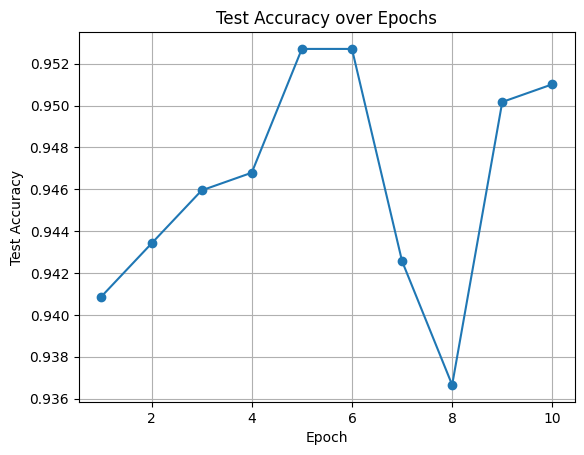

In [24]:
# Plot test accuracy per epoch
plt.plot(range(1, len(test_callback.test_accuracies) + 1), test_callback.test_accuracies, marker='o')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()


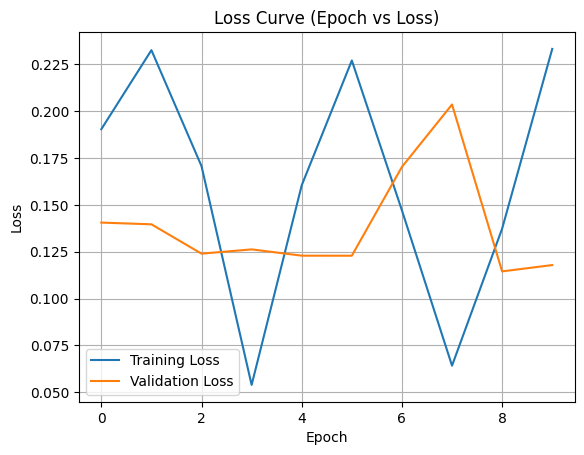

In [28]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Loss Curve (Epoch vs Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Reset the generator to start from the beginning
train_generator.reset()

# Initialize lists for true labels and predictions
train_labels = []
train_predictions = []

# Iterate through the batches
for i in range(train_generator.samples // train_generator.batch_size):
    images, labels = next(train_generator)  # Get batch
    predictions = model.predict(images, verbose=0)  # Predict batch
    train_labels.extend(labels)
    train_predictions.extend(np.round(predictions))  # Round to 0 or 1

# Convert to numpy arrays
train_labels = np.array(train_labels).astype(int)
train_predictions = np.array(train_predictions).astype(int)

# Generate and print confusion matrix
cm_train = confusion_matrix(train_labels, train_predictions)
print("Confusion Matrix for Training Data:")
print(cm_train)


Confusion Matrix for Training Data:
[[6706  186]
 [ 435 6881]]


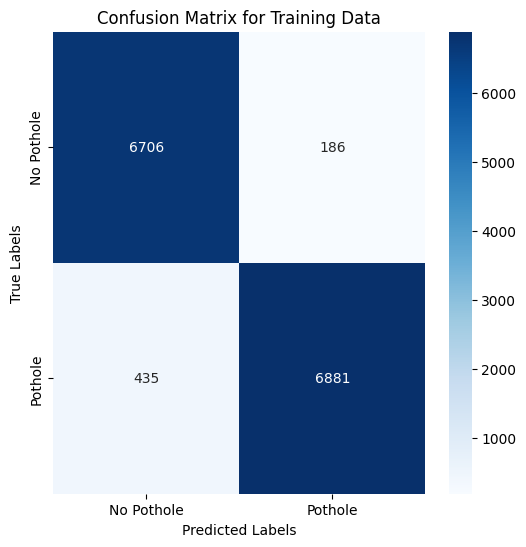

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for the training data
cm_train = confusion_matrix(train_labels, train_predictions)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['No Pothole', 'Pothole'], yticklabels=['No Pothole', 'Pothole'])
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming train_labels and train_predictions are already defined (from previous steps)

# Calculate Accuracy
accuracy = accuracy_score(train_labels, train_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision
precision = precision_score(train_labels, train_predictions)
print(f"Precision: {precision:.4f}")

# Calculate Recall
recall = recall_score(train_labels, train_predictions)
print(f"Recall: {recall:.4f}")

# Calculate F1 Score
f1 = f1_score(train_labels, train_predictions)
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9563
Precision: 0.9737
Recall: 0.9405
F1 Score: 0.9568


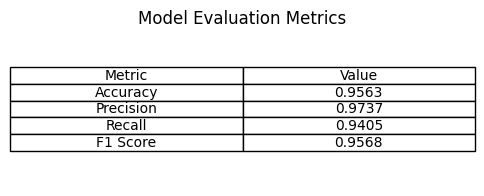

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate the metrics
accuracy = accuracy_score(train_labels, train_predictions)
precision = precision_score(train_labels, train_predictions)
recall = recall_score(train_labels, train_predictions)
f1 = f1_score(train_labels, train_predictions)

# Create the data for the table
metrics = [
    ['Accuracy', f'{accuracy:.4f}'],
    ['Precision', f'{precision:.4f}'],
    ['Recall', f'{recall:.4f}'],
    ['F1 Score', f'{f1:.4f}']
]

# Plotting the table
fig, ax = plt.subplots(figsize=(6, 2))  # Set size of the figure
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics, colLabels=['Metric', 'Value'], loc='center', cellLoc='center')

# Display the table
plt.title("Model Evaluation Metrics")
plt.show()


In [35]:
# Save the model
model.save('VGG19.h5')  # Save as a .h5 file

print("Model saved successfully!")


Model saved successfully!


In [36]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /kaggle/working
